## Bermudan Options (Bermuda is between Europe and America)
 - We assume that this Bermudan option offers the possibilty to execute once each month. 
 - Here we start at 28th of November
 - Starting from November 28, 2023, and considering 252 trading days in a year, the approximate exercise dates for a Bermudan option would be:

 - November 28, 2023
 - December 27, 2023
 - January 25, 2024
 - February 23, 2024
 - March 25, 2024
 - April 23, 2024
 - May 22, 2024
 - June 20, 2024
 - July 19, 2024
 - August 19, 2024
 - September 17, 2024
 - October 16, 2024
 - These dates are determined by selecting every 21st business day (252/12), starting from November 28, 2023. This method provides an even distribution of exercise dates over a year, roughly corresponding to a monthly frequency.  

### 'An Option that can be exercised on specified dates during its life'
 - early execise may be restricted to certain dates
 - nonstandard american options can usually be valued using a binomial tree. At each node, the test (if any) for early exercise is adjusted to reflect the terms of the option

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import math
import datetime
import pandas_datareader as pdr
import datetime
import yfinance as yf
%matplotlib inline

In [2]:
start_date=datetime.datetime(2017,11,28)
end_date=datetime.datetime(2023,11,28)
tickers = 'TSLA'
prices = yf.download(tickers, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
historical = prices['Adj Close'].dropna(how='all')
historical

Date
2017-11-28     21.170000
2017-11-29     20.502666
2017-11-30     20.590000
2017-12-01     20.435333
2017-12-04     20.346666
                 ...    
2023-11-20    235.600006
2023-11-21    241.199997
2023-11-22    234.210007
2023-11-24    235.449997
2023-11-27    236.080002
Name: Adj Close, Length: 1509, dtype: float64

In [4]:
ret = historical.pct_change()[1:] #daily returns for the month
ret

Date
2017-11-29   -0.031523
2017-11-30    0.004260
2017-12-01   -0.007512
2017-12-04   -0.004339
2017-12-05   -0.004915
                ...   
2023-11-20    0.005548
2023-11-21    0.023769
2023-11-22   -0.028980
2023-11-24    0.005294
2023-11-27    0.002676
Name: Adj Close, Length: 1508, dtype: float64

In [5]:
days = len(ret)
sample_mean_tsla = np.mean(ret)
sample_std_tsla = np.std(ret, ddof=1)

sample_mean_tsla,sample_std_tsla

(0.0024043663221886644, 0.040156388904390154)

In [29]:
lastPrice= S0 = historical.iloc[-1]
S0

236.0800018310547

## Monte Carlo Simulation

In [51]:
S = S0
K = 260  # Strike price
r = 0.05  # Risk-free interest rate
T = 1  # Time to expiration (in years)
vol = sample_std_tsla  # Volatility
num_simulations = 1000 # Number of Monte Carlo simulations


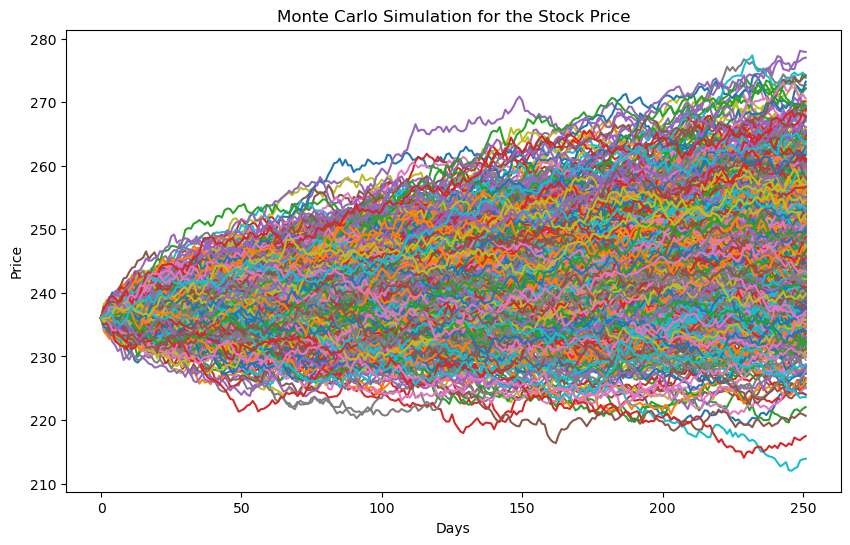

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Monte Carlo option pricing function
def monte_carlo_option_price(S, K, r, T, vol, num_simulations):
    dt = 1/252  # Time step, assuming 252 trading days
    num_days = int(T * 252)  # Number of days until expiration

    simulated_prices = np.zeros((num_simulations, num_days))

    for i in range(num_simulations):
        price_path = np.zeros(num_days)
        price_path[0] = S

        for day in range(1, num_days):
            drift = (r - 0.5 * vol ** 2) * dt
            diffusion = vol * np.sqrt(dt) * np.random.normal(0, 1)
            price_t = price_path[day - 1] * np.exp(drift + diffusion)
            price_path[day] = price_t

        simulated_prices[i, :] = price_path

    return simulated_prices

# Call the Monte Carlo simulation function to simulate price paths
simulated_prices = monte_carlo_option_price(S, K, r, T, vol, num_simulations)

# Plot the simulated stock price paths
plt.figure(figsize=(10, 6))
for i in range(num_simulations):
    plt.plot(simulated_prices[i, :], label=f'Simulation {i + 1}')
plt.title('Monte Carlo Simulation for the Stock Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()


In [53]:
# Adjust the exercise indices to correspond to steps of 21 days from the start date
exercise_indices = np.arange(21, 252, 21)

# Assuming there are 1000 simulations
num_simulations = 1000

# Simulate stock prices for the adjusted exercise indices
# Note: simulated_prices should have been generated previously by a Monte Carlo simulation
simulated_prices = np.zeros((num_simulations, max(exercise_indices) + 1))  # +1 because indices are zero-based

# Initial stock price (S0)
S0 = lastPrice  # This should be the actual initial price used in your Monte Carlo simulation

# Populate the first column of the simulated_prices with the initial stock price
simulated_prices[:, 0] = S0

# Parameters for the Monte Carlo simulation (to be adjusted according to your scenario)
r = 0.05  # Annual risk-free rate
vol = 0.2  # Volatility
T = 1  # Time to maturity in years
dt = 1 / 252  # Time step in years

# Perform the Monte Carlo simulation only for the required days (exercise_indices)
for i in range(1, max(exercise_indices) + 1):
    drift = (r - 0.5 * vol ** 2) * dt
    diffusion = vol * np.sqrt(dt) * np.random.normal(0, 1, num_simulations)
    simulated_prices[:, i] = simulated_prices[:, i - 1] * np.exp(drift + diffusion)

# Compute the payoffs for each simulation at each exercise date
payoffs = np.zeros((num_simulations, len(exercise_indices)))

def call_option_payoff(S, K):
    return np.maximum(S - K, 0)

for i, day_index in enumerate(exercise_indices):
    payoffs[:, i] = call_option_payoff(simulated_prices[:, day_index], K)

# Calculate the average payoff for each exercise date
average_payoffs = np.mean(payoffs, axis=0)

def discount_factor(r, T):
    return np.exp(-r * T)

# Assuming r is the annual risk-free rate as a decimal
r = 0.05

# Adjust the discount periods to match the number of average payoffs
discount_periods = np.arange(1, len(average_payoffs)+1) / 12  # From 1 month to the number of payoffs

# Calculate the discount factors for each period
discount_factors = discount_factor(r, discount_periods)

# Apply the discount factors to the average payoffs
discounted_payoffs = average_payoffs * discount_factors

# The estimated option price is the average of the discounted payoffs
option_price = np.mean(discounted_payoffs)

option_price


6.426589565964273

## Binary or Binomial Tree

In [35]:
u = np.exp(sample_std_tsla * np.sqrt(dt))
d = np.exp(-sample_std_tsla * np.sqrt(dt))
a = np.exp(r/365 * np.sqrt(dt))
p = (a-d)/(u-d)

In [36]:
p #probability of up move

0.5010732623046578

In [34]:
u, d, a, p

(1.0025328169032242, 0.997473582050862, 1.003154669471151, 1.1229143508996353)

In [66]:
# Parameters for the binomial tree
sample_std_tsla = 0.15  # Sample standard deviation for the stock, 15%
dt = 1/252  # Time step, assuming 252 trading days
r = 0.05  # Annual risk-free rate

# Calculate the up and down factors and the probability
u = np.exp(sample_std_tsla * np.sqrt(dt))
d = 1/u  # Down factor is reciprocal if up factor if we assume a binomial model
a = np.exp(r * dt)  # Growth factor for risk-free asset
p = (a - d) / (u - d)  # Probability of an up-move

# Initialize the binomial tree
num_periods = 252
price_tree = np.zeros((num_periods + 1, num_periods + 1))

# Set the initial stock price
S0 = lastPrice  # Starting stock price

In [67]:
# Number of paths to simulate
num_paths = 1000

# Initialize an array to store the simulated paths
simulated_paths = np.zeros((num_paths, num_periods + 1))
simulated_paths[:, 0] = S0  # Set the initial stock price for all paths

# Randomly generate the paths
np.random.seed(0)  # For reproducibility
for path in range(num_paths):
    for day in range(1, num_periods + 1):
        up_move = np.random.rand() < p  # Determine if this step is an up or down move
        if up_move:
            simulated_paths[path, day] = simulated_paths[path, day - 1] * u
        else:
            simulated_paths[path, day] = simulated_paths[path, day - 1] * d

simulated_paths  # Display a few paths to check the output



array([[236.08000183, 233.85976166, 231.66040199, ..., 227.32354046,
        229.48172643, 227.32354046],
       [236.08000183, 233.85976166, 231.66040199, ..., 285.18924427,
        282.50715087, 279.8502815 ],
       [236.08000183, 238.32132073, 236.08000183, ..., 264.42564072,
        266.93607016, 264.42564072],
       ...,
       [236.08000183, 233.85976166, 231.66040199, ..., 227.32354046,
        229.48172643, 227.32354046],
       [236.08000183, 233.85976166, 236.08000183, ..., 301.82508048,
        304.69057629, 301.82508048],
       [236.08000183, 233.85976166, 231.66040199, ..., 245.1737605 ,
        247.50141459, 249.85116719]])

In [68]:
len(simulated_paths)

1000

In [71]:
# Define the intervals for the option exercise dates (every 21 days)
exercise_intervals = np.arange(21, 252 + 21, 21)  # +21 to include the last interval

def call_option_payoff(S, K):
    return np.maximum(S - K, 0)
# Compute the payoffs for each simulation at each exercise date
payoffs_binomial = np.zeros((num_paths, len(exercise_intervals)))

for i, day_index in enumerate(exercise_intervals):
    # Calculate the payoffs for each path at the given exercise date
    payoffs_binomial[:, i] = call_option_payoff(simulated_paths[:, day_index], K)

# Calculate the average payoff for each exercise date
average_payoffs_binomial = np.mean(payoffs_binomial, axis=0)

# Calculate the discount factors for each period
discount_factors_binomial = discount_factor(r, np.arange(1, len(exercise_intervals)+1) / 12)

# Apply the discount factors to the average payoffs
discounted_payoffs_binomial = average_payoffs_binomial * discount_factors_binomial

# The estimated option price is the average of the discounted payoffs
option_price_binomial = np.mean(discounted_payoffs_binomial)

option_price_binomial


4.198925549651304